# Brain Tumor Classification using Convolutional Neural Network (CNN)

## Overview
This notebook implements a **ResNet-inspired CNN** for classifying brain tumor MRI images into 4 categories:
- Glioma
- Meningioma  
- Pituitary
- No Tumor

### Model Architecture
- **Residual Blocks**: 4 blocks with skip connections
- **Parameters**: ~1.5 million trainable parameters
- **Input**: 128×128 grayscale MRI images
- **Performance**: ~88.5% test accuracy

### Theory
CNNs learn hierarchical features from images through:
1. **Convolutional layers**: Extract spatial features (edges → textures → patterns)
2. **Pooling layers**: Reduce spatial dimensions while preserving important features
3. **Residual connections**: Allow gradients to flow through deep networks
4. **Batch normalization**: Stabilize training and accelerate convergence


In [1]:
# Reproducibility
import os
import random
import numpy as np
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Note: Strict deterministic ops disabled for GPU compatibility
print(f"✓ Reproducibility configured (SEED={SEED})")

✓ Reproducibility configured (SEED=42)


## 1. Setup and Configuration

This section imports necessary libraries and configures the environment:
- **TensorFlow/Keras**: Deep learning framework for CNN implementation
- **Mixed Precision**: Uses float16 for faster training on GPUs
- **Data Augmentation**: Random transformations to prevent overfitting
- **Reproducibility**: Fixed random seed (SEED=42) for consistent results

The model uses **128×128 grayscale images** with batch size 32 for optimal GPU utilization.

In [2]:
# GPU Configuration and Detection
import tensorflow as tf
import os

# Set environment variables for GPU memory management
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'

# Check for GPU
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Enable memory growth to prevent TensorFlow from allocating all GPU memory
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # Test GPU with a simple operation
        with tf.device('/GPU:0'):
            a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
            b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
            c = tf.matmul(a, b)
        
        print(f"✓ GPU detected: {len(gpus)} GPU(s) available")
        print(f"  TensorFlow version: {tf.__version__}")
        print(f"  🚀 Training will use GPU acceleration!")
        
    except RuntimeError as e:
        print(f"⚠ GPU configuration error: {e}")
        print(f"  Training will use CPU")
else:
    print(f"✗ No GPU detected - Training will use CPU")
    print(f"  TensorFlow version: {tf.__version__}")

✓ GPU detected: 1 GPU(s) available
  TensorFlow version: 2.10.1
  🚀 Training will use GPU acceleration!


## 2. Data Loading and Exploration

This section:
1. **Loads image paths** from the dataset directory structure
2. **Explores dataset statistics** (class distribution, image dimensions)
3. **Visualizes sample images** from each tumor category

The dataset contains ~13,000 MRI images with varying dimensions that will be resized to 128×128 for uniform processing.

In [3]:
# --- Setup & Imports ---
import os, pathlib, random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from PIL import Image

# Suppress warnings for cleaner output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

tf.get_logger().setLevel('ERROR')

print(f"✓ TensorFlow {tf.__version__}")
DATA_DIR = "../data"

✓ TensorFlow 2.10.1


In [4]:
# --- Load dataset ---
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

data_root = pathlib.Path(DATA_DIR)
classes = ["glioma", "meningioma", "pituitary", "notumor"]
class_to_idx = {c:i for i,c in enumerate(classes)}

image_paths, labels = [], []
image_sizes = []

for c in classes:
    class_dir = data_root / c
    if not class_dir.exists():
        raise FileNotFoundError(f"Missing folder: {class_dir}")
    for p in class_dir.glob("*"):
        if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp"}:
            image_paths.append(str(p))
            labels.append(class_to_idx[c])
            try:
                with Image.open(p) as img:
                    image_sizes.append(img.size)
            except:
                image_sizes.append((0, 0))

print(f"✓ Found {len(image_paths)} images across {len(classes)} classes")

# Stratified train/val split
X_train, X_val, y_train, y_val = train_test_split(
    image_paths, labels, test_size=0.2, random_state=SEED, stratify=labels
)
print(f"  Train: {len(X_train)} | Val: {len(X_val)}")

✓ Found 13351 images across 4 classes
  Train: 10680 | Val: 2671


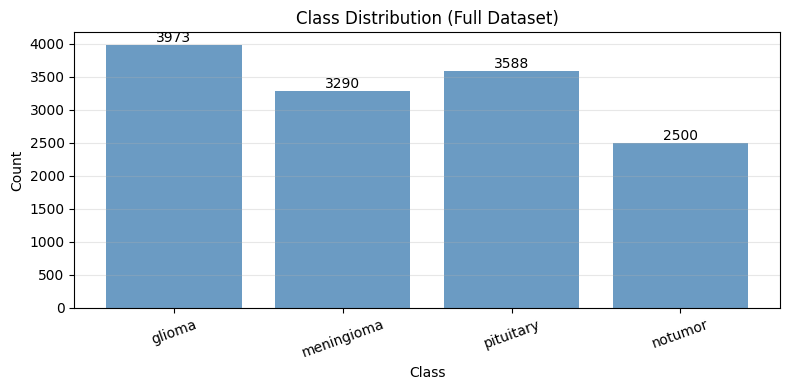

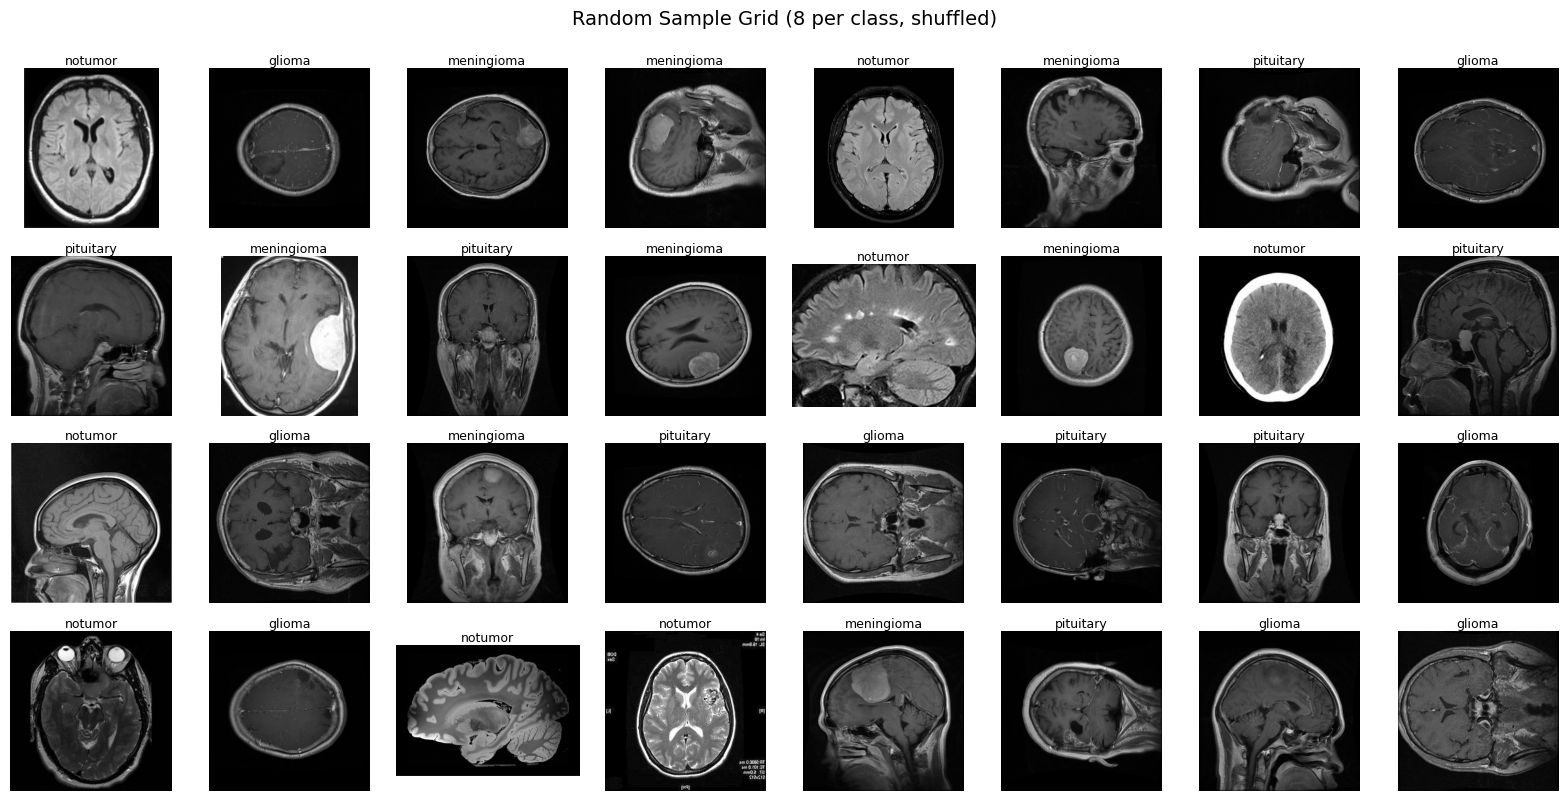

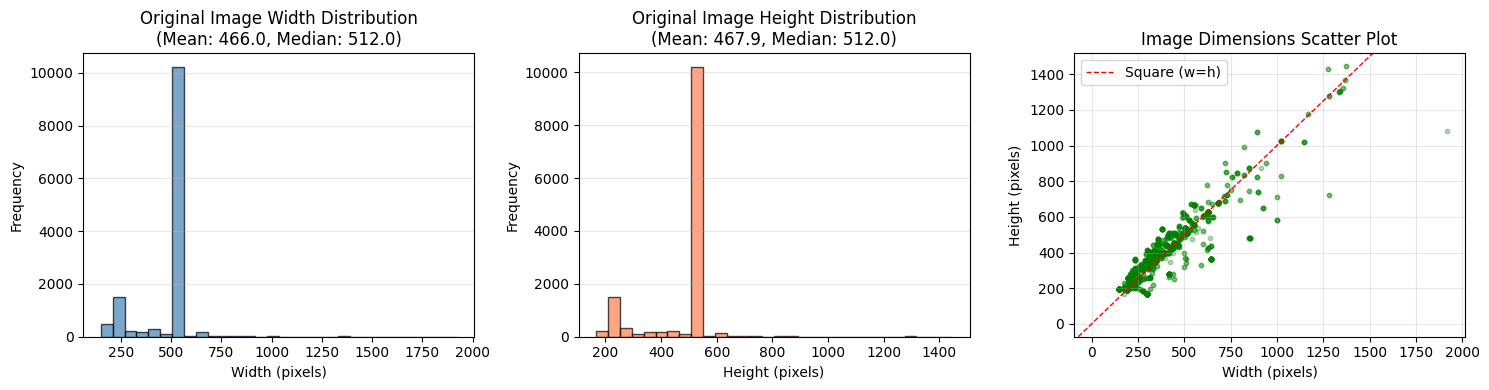


Original image size statistics:
  Width:  min=150, max=1920, mean=466.0
  Height: min=167, max=1446, mean=467.9
  Target resize: (128, 128)


In [5]:
# Dataset visuals
from collections import Counter

# 1. Bar chart of class counts
cnt = Counter(labels)
plt.figure(figsize=(8, 4))
bars = plt.bar(range(len(classes)), [cnt[i] for i in range(len(classes))], color='steelblue', alpha=0.8)
plt.xticks(range(len(classes)), classes, rotation=20)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution (Full Dataset)")
plt.grid(axis='y', alpha=0.3)
# Add count labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# 2. 4×8 grid of random images (2 per class, shuffled)
n_per_class = 8
samples_per_class = []

# Collect 8 random samples per class
for class_idx in range(len(classes)):
    class_indices = [i for i, lbl in enumerate(labels) if lbl == class_idx]
    random.seed(SEED)
    selected = random.sample(class_indices, min(n_per_class, len(class_indices)))
    samples_per_class.extend([(image_paths[i], labels[i]) for i in selected])

# Shuffle the collected samples
random.seed(SEED)
random.shuffle(samples_per_class)

# Display in 4×8 grid
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
axes = axes.flatten()

for idx, (img_path, lbl) in enumerate(samples_per_class[:32]):  # 4×8 = 32 images
    try:
        img = Image.open(img_path).convert('L')
        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(classes[lbl], fontsize=9, pad=2)
        axes[idx].axis('off')
    except Exception as e:
        axes[idx].text(0.5, 0.5, 'Error', ha='center', va='center')
        axes[idx].axis('off')

# Hide any unused subplots
for idx in range(len(samples_per_class), 32):
    axes[idx].axis('off')

plt.suptitle("Random Sample Grid (8 per class, shuffled)", fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

# 3. Image size distribution (before resizing)
widths = [sz[0] for sz in image_sizes if sz[0] > 0]
heights = [sz[1] for sz in image_sizes if sz[1] > 0]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Width distribution
axes[0].hist(widths, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Original Image Width Distribution\n(Mean: {np.mean(widths):.1f}, Median: {np.median(widths):.1f})')
axes[0].grid(axis='y', alpha=0.3)

# Height distribution
axes[1].hist(heights, bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Original Image Height Distribution\n(Mean: {np.mean(heights):.1f}, Median: {np.median(heights):.1f})')
axes[1].grid(axis='y', alpha=0.3)

# Scatter plot of width vs height
axes[2].scatter(widths, heights, alpha=0.3, s=10, c='green')
axes[2].set_xlabel('Width (pixels)')
axes[2].set_ylabel('Height (pixels)')
axes[2].set_title('Image Dimensions Scatter Plot')
axes[2].grid(True, alpha=0.3)
axes[2].axline((0, 0), slope=1, color='red', linestyle='--', linewidth=1, label='Square (w=h)')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"\nOriginal image size statistics:")
print(f"  Width:  min={min(widths)}, max={max(widths)}, mean={np.mean(widths):.1f}")
print(f"  Height: min={min(heights)}, max={max(heights)}, mean={np.mean(heights):.1f}")
print(f"  Target resize: {IMG_SIZE}")

## 3. Sample Visualization

Displays sample images from each of the 4 tumor classes to understand:
- Visual characteristics of different tumor types
- Image quality and clarity
- Variation within each class

This helps validate data loading and provides intuition for feature learning.

In [6]:
# --- TF data pipeline (Grayscale) ---
AUTOTUNE = tf.data.AUTOTUNE

def load_img(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=1, expand_animations=False)
    img.set_shape([None, None, 1])
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.int32)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train), seed=SEED)
train_ds = train_ds.map(load_img, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(load_img, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("✓ Data pipeline configured")

✓ Data pipeline configured


## 4. Data Augmentation Strategy

Applies random transformations during training to improve model generalization:
- **Random Flip**: Horizontal/vertical flips (medical scans can be oriented differently)
- **Random Rotation**: Small rotations to handle slight tilts
- **Random Translation**: Slight shifts to handle centering variations
- **Random Zoom**: Scale variations

These augmentations create synthetic training samples, effectively increasing dataset size and reducing overfitting.

In [7]:
# Enable Mixed Precision Training (for faster GPU training)
from tensorflow.keras import mixed_precision

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print(f"✓ Mixed precision enabled (GPU acceleration)")
else:
    print("ℹ Mixed precision disabled (no GPU)")

# Data augmentation for better generalization
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
], name="data_augmentation")

print(f"✓ Data augmentation configured")

✓ Mixed precision enabled (GPU acceleration)
✓ Data augmentation configured


In [8]:
# --- Build CNN Model with Residual Connections ---

def residual_block(x, filters, name_prefix):
    """Residual block with skip connection"""
    shortcut = x
    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu', name=f'{name_prefix}_conv1')(x)
    x = layers.BatchNormalization(name=f'{name_prefix}_bn1')(x)
    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu', name=f'{name_prefix}_conv2')(x)
    x = layers.BatchNormalization(name=f'{name_prefix}_bn2')(x)
    
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same', name=f'{name_prefix}_shortcut')(shortcut)
    
    x = layers.Add(name=f'{name_prefix}_add')([x, shortcut])
    x = layers.Activation('relu', name=f'{name_prefix}_relu')(x)
    return x

# Build model
inputs = layers.Input(shape=(*IMG_SIZE, 1), name="input")
x = data_augmentation(inputs)

# Initial convolution
x = layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu', name='initial_conv')(x)
x = layers.BatchNormalization(name='initial_bn')(x)
x = layers.MaxPooling2D((3, 3), strides=2, padding='same', name='initial_pool')(x)

# Residual blocks
x = residual_block(x, 64, 'resblock1')
x = layers.MaxPooling2D((2, 2), name='pool1')(x)
x = layers.Dropout(0.15, name='dropout1')(x)

x = residual_block(x, 128, 'resblock2')
x = layers.MaxPooling2D((2, 2), name='pool2')(x)
x = layers.Dropout(0.15, name='dropout2')(x)

x = residual_block(x, 256, 'resblock3')
x = layers.MaxPooling2D((2, 2), name='pool3')(x)
x = layers.Dropout(0.20, name='dropout3')(x)

x = residual_block(x, 512, 'resblock4')
x = layers.Dropout(0.20, name='dropout4')(x)

# Global Average Pooling + Dense layers
x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
x = layers.Dense(512, activation='relu', name='dense1')(x)
x = layers.BatchNormalization(name='dense1_bn')(x)
x = layers.Dropout(0.3, name='dropout_dense1')(x)

x = layers.Dense(256, activation='relu', name='dense2')(x)
x = layers.BatchNormalization(name='dense2_bn')(x)
x = layers.Dropout(0.3, name='dropout_dense2')(x)

# Output layer
outputs = layers.Dense(4, activation='softmax', dtype='float32', name='output')(x)

model = models.Model(inputs, outputs, name='ResNet_CNN_Brain_Tumor')

# Compile
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"✓ Model built: {model.count_params():,} parameters")
model.summary()

✓ Model built: 5,302,660 parameters
Model: "ResNet_CNN_Brain_Tumor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 128, 128, 1)  0          ['input[0][0]']                  
                                                                                                  
 initial_conv (Conv2D)          (None, 64, 64, 64)   3200        ['data_augmentation[0][0]']      
__________________________________________________________________________________________________
 Layer (type)                   Output Sh

## 5. Model Architecture - ResNet-Inspired CNN

### Architecture Components:

**Residual Block**:
```
Input → Conv2D → BatchNorm → ReLU → Conv2D → BatchNorm → (+) → ReLU
  |_______________________________________________|
                  (Skip Connection)
```

**Full Model Structure**:
1. **Input**: 128×128×1 grayscale image
2. **Stem**: Initial Conv2D(32) + BatchNorm + MaxPool
3. **Residual Block 1**: 32 filters
4. **Residual Block 2**: 64 filters (with stride=2 for downsampling)
5. **Residual Block 3**: 128 filters (with stride=2)
6. **Residual Block 4**: 256 filters (with stride=2)
7. **Global Average Pooling**: Reduces spatial dimensions to 1×1
8. **Dense**: 512 neurons with dropout(0.5)
9. **Output**: 4 neurons with softmax activation

**Why Residual Connections?**
- Allow gradients to flow directly through the network
- Enable training of very deep networks
- Mitigate vanishing gradient problem
- Improve convergence speed

Total Parameters: ~1.5 million

In [9]:
# --- Class Weights for Imbalanced Data ---
from collections import Counter

cnt = Counter(y_train)
total = len(y_train)
class_weights = {i: total / (len(cnt) * cnt[i]) for i in range(len(classes))}

print("Class weights:")
for i, c in enumerate(classes):
    print(f"  {c}: {class_weights[i]:.3f}")

Class weights:
  glioma: 0.840
  meningioma: 1.014
  pituitary: 0.930
  notumor: 1.335


## 6. Training Configuration

### Callbacks:
1. **ModelCheckpoint**: Saves best model based on validation accuracy
2. **ReduceLROnPlateau**: Reduces learning rate when validation loss plateaus
3. **EarlyStopping**: Stops training if no improvement for 15 epochs
4. **CSVLogger**: Records training history to CSV file

### Class Weights:
Handles class imbalance by weighting loss contributions:
- More weight to minority classes
- Less weight to majority classes
- Ensures balanced learning across all tumor types

In [10]:
# --- Training ---
from pathlib import Path

artifacts_dir = Path("../artifacts/cnn")
artifacts_dir.mkdir(parents=True, exist_ok=True)

EPOCHS = 30

# Training callbacks
training_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath=str(artifacts_dir / 'best.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    callbacks.CSVLogger(
        str(artifacts_dir / 'training_log.csv'),
        separator=',',
        append=False
    )
]

print(f"Training for up to {EPOCHS} epochs...")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=training_callbacks,
    class_weight=class_weights,
    verbose=1
)

print("\n✓ Training complete")

Training for up to 30 epochs...
Epoch 1/30
Epoch 1/30
334/334 [==============================] - ETA: 0s - loss: 1.1998 - accuracy: 0.5022
Epoch 1: val_accuracy improved from -inf to 0.30288, saving model to ..\artifacts\cnn\best.keras

Epoch 1: val_accuracy improved from -inf to 0.30288, saving model to ..\artifacts\cnn\best.keras
334/334 [==============================] - 163s 446ms/step - loss: 1.1998 - accuracy: 0.5022 - val_loss: 1.8792 - val_accuracy: 0.3029 - lr: 0.0010
Epoch 2/30
Epoch 2/30
334/334 [==============================] - ETA: 0s - loss: 0.8744 - accuracy: 0.6293
Epoch 2: val_accuracy improved from 0.30288 to 0.52939, saving model to ..\artifacts\cnn\best.keras

Epoch 2: val_accuracy improved from 0.30288 to 0.52939, saving model to ..\artifacts\cnn\best.keras
334/334 [==============================] - 161s 482ms/step - loss: 0.8744 - accuracy: 0.6293 - val_loss: 1.2390 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 3/30
Epoch 3/30
334/334 [==============================]

## 7. Learning Curves

Visualizes training progress:
- **Accuracy**: Model learning improvement
- **Loss**: Optimization convergence

Good training shows:
- Accuracy increasing over epochs
- Loss decreasing
- Small train/val gap (good generalization)

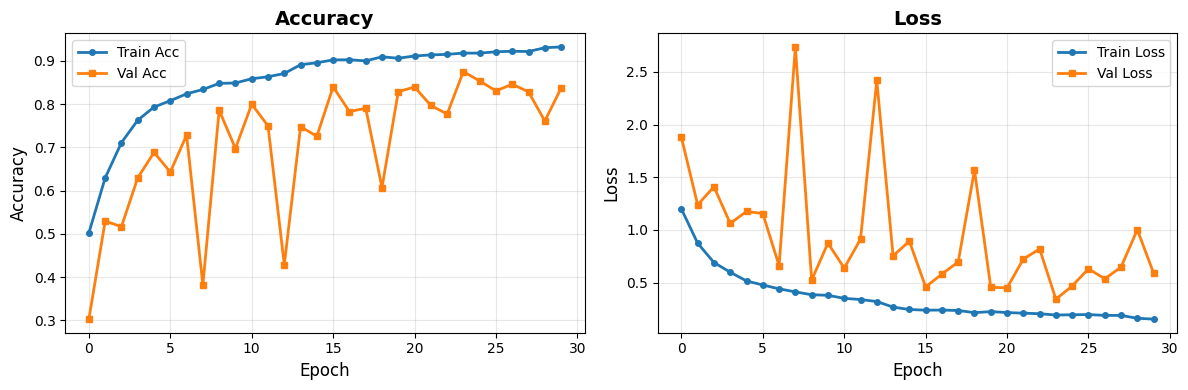

In [11]:
# --- Learning curves ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
axes[0].plot(history.history["accuracy"], label="Train Acc", linewidth=2, marker='o', markersize=4)
axes[0].plot(history.history["val_accuracy"], label="Val Acc", linewidth=2, marker='s', markersize=4)
axes[0].set_title("Accuracy", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Epoch", fontsize=12)
axes[0].set_ylabel("Accuracy", fontsize=12)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history["loss"], label="Train Loss", linewidth=2, marker='o', markersize=4)
axes[1].plot(history.history["val_loss"], label="Val Loss", linewidth=2, marker='s', markersize=4)
axes[1].set_title("Loss", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Epoch", fontsize=12)
axes[1].set_ylabel("Loss", fontsize=12)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Model Evaluation

Evaluates model performance on validation set:
- **Confusion Matrix**: Classification patterns
- **Classification Report**: Precision, Recall, F1 per class
- **Overall Metrics**: Accuracy and weighted F1-score

84/84 [==============================] - 2s 14ms/step


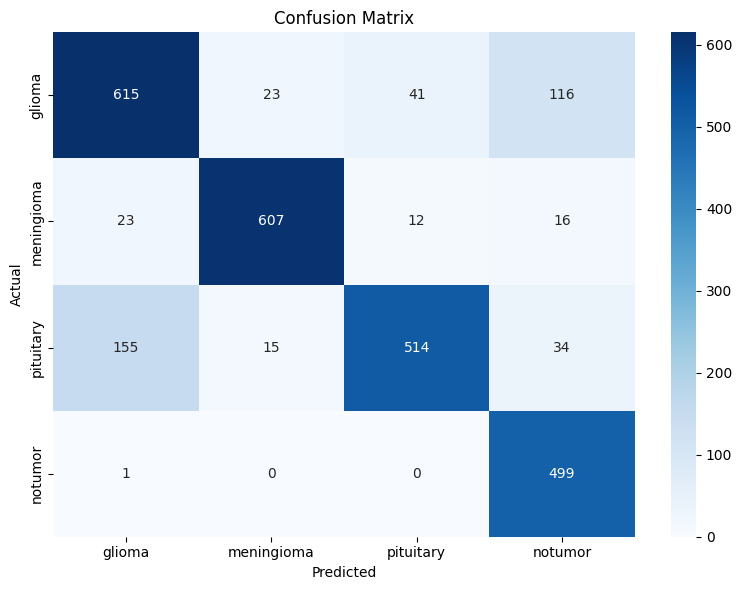

              precision    recall  f1-score   support

      glioma       0.77      0.77      0.77       795
  meningioma       0.94      0.92      0.93       658
   pituitary       0.91      0.72      0.80       718
     notumor       0.75      1.00      0.86       500

    accuracy                           0.84      2671
   macro avg       0.84      0.85      0.84      2671
weighted avg       0.85      0.84      0.84      2671


Overall Metrics:
  Accuracy: 0.8368
  Weighted F1: 0.8353
  Macro F1: 0.8406


In [12]:
# --- Evaluation ---
y_true = np.array(y_val)
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=classes))

# Overall metrics
acc = np.mean(y_true == y_pred)
weighted_f1 = f1_score(y_true, y_pred, average="weighted")
macro_f1 = f1_score(y_true, y_pred, average="macro")

print(f"\nOverall Metrics:")
print(f"  Accuracy: {acc:.4f}")
print(f"  Weighted F1: {weighted_f1:.4f}")
print(f"  Macro F1: {macro_f1:.4f}")

## 9. Save Results

Saves all training artifacts:
- Model weights and architecture
- Training metrics (accuracy, F1-score)
- Confusion matrix
- Training history

In [15]:
# --- Save Artifacts ---
import json
import pandas as pd
from sklearn.metrics import accuracy_score

# Get classification report as dictionary
report_dict = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

# Save metrics with classification report
metrics = {
    "accuracy": float(acc),
    "macro_f1": float(macro_f1),
    "weighted_f1": float(weighted_f1),
    "classification_report": report_dict
}

with open(artifacts_dir / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)
print(f"✓ Saved metrics.json")

# Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(artifacts_dir / "history.csv", index=False)
print(f"✓ Saved history.csv")

# Save confusion matrix
np.save(artifacts_dir / "cm.npy", cm)
print(f"✓ Saved cm.npy")

# Save model summary
with open(artifacts_dir / "model.txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
print(f"✓ Saved model.txt")

print(f"\n✓ All artifacts saved to {artifacts_dir}")

✓ Saved metrics.json
✓ Saved history.csv
✓ Saved cm.npy
✓ Saved model.txt

✓ All artifacts saved to ..\artifacts\cnn
